In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [32]:

def rastrigin_function(x, A=10):
    p = len(x)
    return A * p + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

In [33]:
def initialize_population(pop_size, chromosome_length):
    return np.random.randint(2, size=(pop_size, chromosome_length))

In [34]:
def decode_chromosome(chromosome, num_dimensions, bits_per_dimension, domain=(-10, 10)):
    split = np.split(chromosome, num_dimensions)
    real_values = []
    for bit_array in split:
        decimal_value = int("".join(str(bit) for bit in bit_array), 2)
        min_domain, max_domain = domain
        real_value = min_domain + ((max_domain - min_domain) / ((2**bits_per_dimension) - 1)) * decimal_value
        real_values.append(real_value)
    return real_values

In [35]:
def roulette_wheel_selection(population, fitness_scores):
    total_fitness = sum(fitness_scores)
    selection_probabilities = [fitness / total_fitness for fitness in fitness_scores]
    return population[np.random.choice(len(population), p=selection_probabilities)]

In [36]:
def two_point_crossover(parent1, parent2):
    size = len(parent1)
    crossover_point1, crossover_point2 = sorted(np.random.choice(range(1, size), 2, replace=False))
    offspring1 = np.concatenate([parent1[:crossover_point1], parent2[crossover_point1:crossover_point2], parent1[crossover_point2:]])
    offspring2 = np.concatenate([parent2[:crossover_point1], parent1[crossover_point1:crossover_point2], parent2[crossover_point2:]])
    return offspring1, offspring2

In [37]:
def mutate(chromosome, mutation_rate):
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]  
    return chromosome

In [73]:
def genetic_algorithm(pop_size, chromosome_length, num_dimensions, bits_per_dimension, num_generations, mutation_rate):
    population = initialize_population(pop_size, chromosome_length)
    best_solution = None
    best_fitness = float('inf')
    generation_data = []
    
    for generation in range(num_generations):
        decoded_population = [decode_chromosome(chromo, num_dimensions, bits_per_dimension) for chromo in population]
        fitness_scores = [rastrigin_function(individual) for individual in decoded_population]
        
        current_best_fitness = min(fitness_scores)
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_solution = decoded_population[fitness_scores.index(best_fitness)]
        
        new_population = []
        for _ in range(pop_size // 2):
            parent1 = roulette_wheel_selection(population, fitness_scores)
            parent2 = roulette_wheel_selection(population, fitness_scores)
            offspring1, offspring2 = two_point_crossover(parent1, parent2)
            new_population.extend([offspring1, offspring2])
        
        min_fitness = min(fitness_scores)
        max_fitness = max(fitness_scores)
        mean_fitness = np.mean(fitness_scores)
        
        generation_data.append({
            "Generation": generation,
            'Score Fitness': fitness_scores,
            "Min Fitness": min_fitness,
            "Max Fitness": max_fitness,
            "Mean Fitness": mean_fitness,
        })
        
        population = [mutate(offspring, mutation_rate) for offspring in new_population]
    
    df = pd.DataFrame(generation_data)
    df.to_csv("generation_data.csv", index=False)
    
    return best_solution, best_fitness, df

            Min Fitness  Max Fitness  Mean Fitness  Std Fitness
Generation                                                     
0            580.783274  1191.498550    877.600178   126.724230
1            609.412632  1199.250955    904.309742   128.144651
2            552.419854  1184.874384    923.689859   135.574434
3            714.211521  1289.748084    945.652579   113.900060
4            639.678818  1325.979898    958.365382   127.498607
...                 ...          ...           ...          ...
95           881.337763  1742.599963   1271.490800   152.259034
96           883.728599  1570.937675   1277.105204   145.223441
97           941.970084  1576.790826   1307.893160   134.849701
98          1030.175069  1609.525776   1307.544957   140.603502
99           860.902694  1844.402527   1284.489975   164.732802

[100 rows x 4 columns]


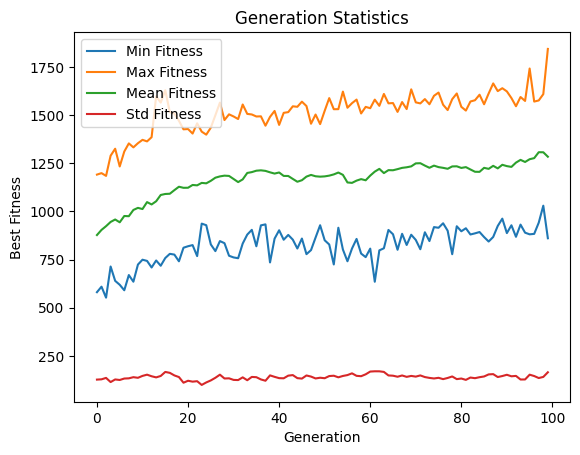

In [77]:
best_solution, best_fitness, df = genetic_algorithm(
    pop_size=100, chromosome_length=200, num_dimensions=20, bits_per_dimension=10,
    num_generations=100, mutation_rate=0.01
)

df['Std Fitness'] = df['Score Fitness'].apply(np.std)

stats_df = df.groupby('Generation').agg({
    'Min Fitness': 'min',
    'Max Fitness': 'max',
    'Mean Fitness': 'mean',
    'Std Fitness': 'mean'
})

print(stats_df)

stats_df.plot(kind='line')
plt.title('Generation Statistics')
plt.ylabel('Best Fitness')
plt.show()